# Polynomial Ridge Regression

Welcome to your third lab! You will build more Polynomial Regression with L2 regularization.

You will be predicting temperature by day time.

This lab is a little bit more complex than first two. You will implement this model in OOP way.

**You will learn to:**
- Build the general architecture of a learning algorithm with OOP in mind:
    - Helper functions
        - Generation of polynomial_features
        - Calculation of Mean Squared Error
        - L2 regularization
    - Main Model Class
        - Initializing parameters
        - Training
        - Prediction 


## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment.
- [math](https://docs.python.org/3/library/math.html) - just math ;)
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## 2 - Overview of the Problem set ##

**Problem Statement**: You are given a dataset  containing:
    - a training set of m_train examples
    - a test set of m_test examples
    - each example is of shape (number of features, 1), in our case (1, 1)

Let's get more familiar with the dataset. Load the data by running the following code.

In [2]:
# Loading the data

def load_data():
    from sklearn.model_selection import train_test_split

    data = np.genfromtxt('time_temp_2016.tsv', delimiter='\t')
    
    x = data[:, 0]
    x = x.reshape((x.shape[0], 1))
    y = data[:, 1]
    
    train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(x, y, test_size=0.33, random_state=42)
    
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
    return train_set_x.T, test_set_x.T, train_set_y, test_set_y, x.T

train_set_x, test_set_x, train_set_y, test_set_y, full_feature_set_for_plot = load_data()

In [3]:
print(train_set_x.shape, train_set_y.shape, test_set_x.shape, test_set_y.shape)

(1, 245) (1, 245) (1, 121) (1, 121)


Many software bugs in machine learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

**Exercise:** Find the values for:
    - m_train (number of training examples)
    - m_test (number of test examples)


In [4]:
### START CODE HERE ### (≈ 2 lines of code)
m_train = len(train_set_x[0])
m_test = len(test_set_x[0])
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))

print ("\ntrain_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 245
Number of testing examples: m_test = 121

train_set_x shape: (1, 245)
train_set_y shape: (1, 245)
test_set_x shape: (1, 121)
test_set_y shape: (1, 121)


**Expected Output for m_train, m_test**: 
<table style="width:15%">
  <tr>
      <td><b>m_train</b></td>
    <td> 245 </td> 
  </tr>
  
  <tr>
    <td><b>m_test</b></td>
    <td> 121 </td> 
  </tr>
</table>


### Data visualization
To familiarize oneself with the data obtained, we will plot the `Temperature` as a function of `Day`. Since our `Day` feature was already normalized to 0-1 range, we will multiply it by 366 to restore the correct day of the year. Let's also add different colors to train and test samples to make it fancy.

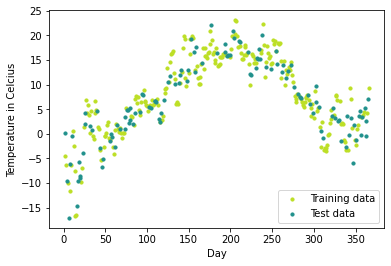

In [5]:
# Color map
cmap = plt.get_cmap('viridis')

# Plot the results
m1 = plt.scatter(366 * train_set_x, train_set_y, color=cmap(0.9), s=10)
m2 = plt.scatter(366 * test_set_x, test_set_y, color=cmap(0.5), s=10)
plt.xlabel('Day')
plt.ylabel('Temperature in Celcius')
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.show()

## 3 - Polynomial Ridge Regression algorithm
**Mathematical expression of the algorithm**:
For one example $x^{(i)}$:

Main trick of polynomial regression - feature combination under predefined degree.
Let's define our $degree = 3$ and $x^{(i)} = (x_{1})$ - so that we have only one feature as in our current dataset for the sake of simplicity(later you will see generalized solution for any amount of features and any degree).

So, having $degree = 3$ and $x^{(i)} = (x^{(i)}_{1})$ we transform our feature vector to be:
$$x^{(i)} = ((x^{(i)}_{1})^0=1, x^{(i)}_{1}, (x^{(i)}_{1})^2, (x^{(i)}_{1})^3)$$

Having more than 1 features would cause combinations with replacements for each feature under each degree in range [0, $degree$].

After that step we have regular well known process, but in this lab we will use a little trick with bias variable.
You should already be familiar with it.

Main idea is to add 1 to each training example on the first position. It gives us an ability to count our bias inside of the weights vector on the first position too. So, now our $x^{(i)}$ will look like this:
$$x^{(i)} = (1, (x^{(i)}_{1})^0=1, x^{(i)}_{1}, (x^{(i)}_{1})^2, (x^{(i)}_{1})^3)$$

So, predictor function:
$$h^{(i)} =  w^T x^{(i)} \tag{1}$$

<b>Ridge</b> a.k.a <b>L2 Regularization</b>.
Having really high order polynomial function we can easily overfit on our training set.
The main technique to prevent overfitting called regularization.
You should already be familiar with theory of l2 regularization. Our cost function will look like this:

The cost is then computed by summing squared diff over all training examples:
$$J = \frac{1}{2}\sum_{i=1}^{m}(h^{(i)} - y^{(i)})^{2} + \frac{1}{2}\lambda ||w||^2_2\tag{2}$$

Where $\lambda$ is regularization term and $||w||_2$ is Euclidean norm.

Now, only gradient have to be defined.
$$X = (x^{(1)}, x^{(2)}, ..., x^{(m-1)}, x^{(m)})$$
$$H = w^T X = (h^{(1)}, h^{(2)}, ..., h^{(m-1)}, h^{(m)})$$

$$ \frac{\partial J}{\partial w} = X(H-Y)^T + \lambda w \tag{3}$$



### 3.1 Helper utilities

In this exercise, you will learn more about custom implemenation of 
    - Generation of polynomial_features
    - Calculation of Mean Squared Error
    - L2 regularization

Let's get more detailed look at these functions:

We create function polynomial_features to transform our flat input features into features of higher degrees.

As example for degree=3 and features $(x_1, x_2, x_3)$ we will get:

$$((x_1, x_2, x_3),3) -> (1, x_1, x_2, x_3, x^2_1, x_1 x_2, x_1 x_3, x^2_2, x_2 x_3, x^2_3, x^3_1, x^2_1 x_2, x^2_1 x_3,  x_1 x^2_2, x_1 x_2 x_3, x_1 x^2_3, x^3_2, x^2_2 x_3, x_2 x^2_3, x^3_3)$$

In [6]:
def polynomial_features(X, degree):
    
    from itertools import combinations_with_replacement 
    # combinations_with_replacement('ABC', 2) --> AA AB AC BB BC CC
    
    n_features, n_samples = np.shape(X)
    
    def index_combinations(): ## (1, 2) => [(1),(2),(1,1),(1,2),(2,2)]
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
        ##comb = [(),((1),(2)),((1,1),(1,2),(2,2))]
        flat_combs = [item for sublist in combs for item in sublist]
        ##flat_combs = [(1),(2),(1,1),(1,2),(2,2)]
        return flat_combs
    
    combinations = index_combinations()
    
    n_output_features = len(combinations)
    
    X_new = np.empty((n_output_features, n_samples))
    
    for i, index_combs in enumerate(combinations):  
        X_new[i, :] = np.prod(X[index_combs, :], axis=0)
        ## if index_combs == (1,2,3) =>  X_new[:,i] = X[:,1] * X[:,2] * X[:,3] 
    return X_new

We will be using mean squared error to evaluate accuracy of our model:

$$
MSE=\frac{1}{m}\sum_{i=1}^{m}{(h^{(i)} - y^{(i)})^2} 
$$

In [7]:
# GRADED FUNCTION: mean_squared_error

def mean_squared_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred 
    
    Arguments:
    y_true -- array of true values
    y_pred -- array of predicted values
    
    Returns:
    mse -- mean squared error
    """
    ### START CODE HERE ### (≈ 1 line of code)
    mse=(1/len(y_true.T))*np.sum((y_true-y_pred)**2)
    ### END CODE HERE ###

    return mse

In [8]:
print ("mse = " + str(mean_squared_error(np.array([1, 2, 3, 4]), np.array([2, 3, 4, 6]))))

mse = 1.75


**Expected Output**: 
<table style="width:15%">
    <tr>
         <td>
             <b>mse</b>
         </td>
         <td>
            1.75
         </td>  
   </tr>
</table>

Ridge regression a.k.a. L2 regularization(we will use alpha instead of lambda in the code because of python lambda keyword).

In [9]:
# GRADED CLASS: l2_regularization

class l2_regularization():
    """ Regularization for Ridge Regression """
    def __init__(self, alpha):
        """ Set alpha """
        self.alpha = alpha
    
    def __call__(self, w):
        """ 
        Computes l2 regularization term
        
        Arguments:
        w -- weights

        Returns:
        term -- 1/2 * alpha * norm(w)^2
        """
        ### START CODE HERE ### (≈ 1 line of code)
        term =  1/2 * self.alpha * np.linalg.norm(w)**2
        ### END CODE HERE ###        
        return term

    def grad(self, w):
        """ 
        Computes derivative of l2 regularization term
        
        Arguments:
        w -- weights

        Returns:
        vector -- alpha * w
        """
        ### START CODE HERE ### (≈ 1 line of code)
        derivative = self.alpha*w
        ### END CODE HERE ###      
        
        return derivative

In [10]:
l2 = l2_regularization(0.5)
print ("l2 reg. term = " + str(l2(np.array([1, 2, 3, 4]))))
print ("l2 grad. = " + str(l2.grad(np.array([1, 2, 3, 4]))))

l2 reg. term = 7.5
l2 grad. = [0.5 1.  1.5 2. ]


**Expected Output**: 

<table style="width:30%">
    <tr>
        <td><b>l2 reg. term</b></td>
       <td> 7.5 </td>
    </tr>
    <tr>
        <td><b>l2 grad.</b></td>
       <td> [0.5 1.  1.5 2. ] </td>
    </tr>

</table>

### 3.2 Model

In [11]:
# GRADED CLASS: PolynomialRidgeRegression

class PolynomialRidgeRegression(object):
    """
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: int
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, reg_factor, n_iterations=3000, learning_rate=0.01, print_error=False):
        self.degree = degree
        self.regularization = l2_regularization(alpha=reg_factor)
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.print_error = print_error
    
        
    def initialize_with_zeros(self, n_features):
        """
        This function creates a vector of zeros of shape (n_features, 1)
        
        Arguments:
        n_features -- amount of features
        """
        ### START CODE HERE ### (≈ 1 line of code)
        self.w = np.zeros((n_features,1))
        ### END CODE HERE ###
        
        
    def fit(self, X, Y):
        ### START CODE HERE ### 
        # Generate polynomial features (≈ 1 line of code)
        X = polynomial_features(X, self.degree)

        # Insert constant ones for bias weights (≈ 1 line of code)
        X = np.concatenate((np.ones((1,len(X[0]))),X),axis=0)
        
        # Create array
        self.initialize_with_zeros(n_features=X.shape[0])

        # Do gradient descent for n_iterations
        for i in range(self.n_iterations):
            # Calculate prediction (≈ 1 line of code)
            H = self.w.T.dot(X)

            # Gradient of l2 loss w.r.t w (≈ 1 line of code)
            grad_w = np.dot(X,(H-Y).T) + self.regularization.grad(self.w) 

            # Update the weights (≈ 1 line of code)
            self.w = self.w - self.learning_rate*grad_w

            if self.print_error and i % 1000 == 0:
                # Calculate l2 loss (≈ 1 line of code)
                mse = mean_squared_error(Y, H)
                ### END CODE HERE ###
                print ("MSE after iteration %i: %f" %(i, mse))
        
            
    def predict(self, X):
        ### START CODE HERE ### 
        X = polynomial_features(X, self.degree)
        
        
        X = np.concatenate((np.ones((1,len(X[0]))),X),axis=0)
       
        y_pred = self.w.T.dot(X)
        ### END CODE HERE ### 
        
        return y_pred

## 4 - Training

First of all, we should define a maximum possible polynomial degree (`poly_degree`),  learning rate (`learning_rate`), a number of iterations (`num_iteration`) and regularization factor (`reg_factor`) for our model. Often `reg_factor` is chosen with help of cross-validation.

In [12]:
poly_degree = 15
learning_rate = 0.001
n_iterations = 10000
reg_factor = 0.1

Now we can initialize our model:

In [13]:
model = PolynomialRidgeRegression(
    degree=poly_degree, 
    reg_factor=reg_factor,
    learning_rate=learning_rate,
    n_iterations=n_iterations,
    print_error=True
)

Let's train our model:

In [14]:
model.fit(train_set_x, train_set_y)

MSE after iteration 0: 127.482367
MSE after iteration 1000: 14.568897
MSE after iteration 2000: 12.862790
MSE after iteration 3000: 12.687616
MSE after iteration 4000: 12.652576
MSE after iteration 5000: 12.640050
MSE after iteration 6000: 12.632690
MSE after iteration 7000: 12.627097
MSE after iteration 8000: 12.622458
MSE after iteration 9000: 12.618504


**Expected Output**: 

<table style="width:50%"> 
    <tr>
        <td><b>MSE after iteration 0 </b></td> 
        <td> 127.482367 </td>
    </tr>
      <tr>
        <td> <center> $\vdots$ </center> </td> 
        <td> <center> $\vdots$ </center> </td> 
    </tr>  
    <tr>
        <td><b>MSE after iteration 9000</b></td> 
        <td> 12.618504 </td>
    </tr>
</table> 

## 4 - Making predictions

In [15]:
y_predictions = model.predict(test_set_x)

Let's calculate mean squred error(MSE):

In [16]:
mse = mean_squared_error(test_set_y, y_predictions)

In [17]:
print ("Mean squared error on test set: %s (given by reg. factor: %s)" % (mse, reg_factor))

Mean squared error on test set: 11.01910317263094 (given by reg. factor: 0.1)


**Expected Output**: 

<table style="width:30%"> 
    <tr>
        <td style="width:15%"> <b>MSE</b></td> 
        <td> 11.01910317263094 </td>
    </tr>
</table> 

## 5 - Results visualization

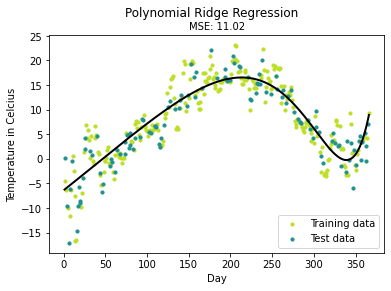

In [18]:
# Color map
cmap = plt.get_cmap('viridis')

# Predict for all points in set
y_val = model.predict(full_feature_set_for_plot)

# Plot the results
m1 = plt.scatter(366 * train_set_x, train_set_y, color=cmap(0.9), s=10)
m2 = plt.scatter(366 * test_set_x, test_set_y, color=cmap(0.5), s=10)
plt.plot(366 * full_feature_set_for_plot.T, y_val.T, color='black', linewidth=2, label="Prediction")
plt.suptitle("Polynomial Ridge Regression")
plt.title("MSE: %.2f" % mse, fontsize=10)
plt.xlabel('Day')
plt.ylabel('Temperature in Celcius')
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.show()

## 6 - Conclusion
As we can see, our model fits well the hypothesis function to the data. Despite having high-degree polynomials, we prevented overfitting by using the **L2 Regularization** - method for penalizing high magnitudes of parameters estimates. 

#### What's next:
1. Try experimenting with the `reg_factor` to see how this affects the model you have built.
2. Compare the results you have obtained with the `sklearn.linear_model.Ridge` model.
3. Try this model in the wild! Select your favorite dataset [here](https://www.kaggle.com/datasets?sortBy=hottest&group=public&page=1&pageSize=20&size=small&filetype=all&license=all&tagids=13303), play with it, reiterate.